In [140]:
import numpy as np
import sklearn
from skimage import transform
import matplotlib.pyplot as plt
from scipy.datasets import ascent
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning

(512, 512)


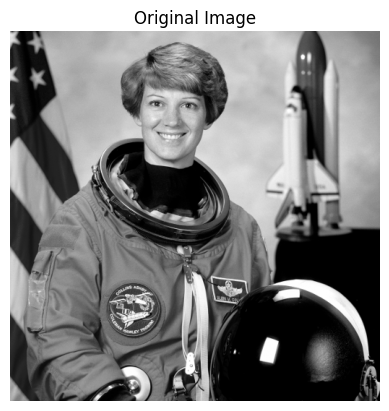

(256, 256)


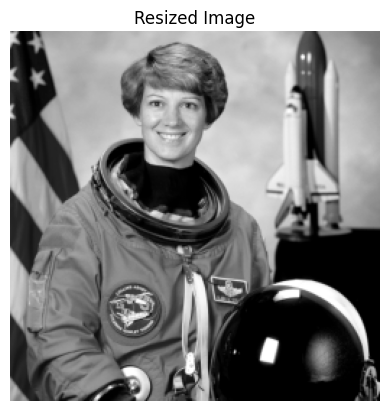

In [141]:
import matplotlib.pyplot as plt
from skimage import data, color, transform

# Step 1: Load the image
face = data.astronaut()  # RGB image
face_gray = color.rgb2gray(face)  # Convert to grayscale

print(face_gray.shape)

plt.imshow(face_gray, cmap='gray')
plt.title("Original Image")
plt.axis('off')
plt.show()

# Image dimensions
H, W = face_gray.shape  # image height, image width
pH, pW = 4, 4  # patch height, patch width

# Resize image to half its size
face_resized = transform.resize(face_gray, (H // 2, W // 2), anti_aliasing=True)

print(face_resized.shape)

plt.imshow(face_resized, cmap='gray')
plt.title("Resized Image")
plt.axis('off')
plt.show()

In [142]:
face_gray.shape[0]

512

Number of patches: 30000
Visualization of some patches


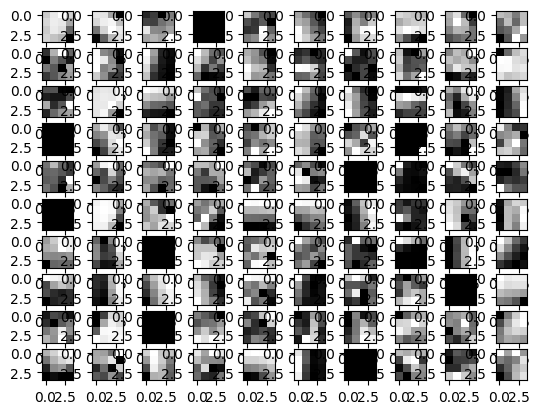

In [143]:
# Step 2: Sample the patches from the image to learn.
# Let set the number of patches to 30000
#num_patches = 30000  # Number of patches to extract
patches = extract_patches_2d(face_gray,(pH, pW),max_patches=30000);### YOUR CODE HERE ###
print('Number of patches: %d' %patches.shape[0],)

# randomly shuffle the patches
np.random.shuffle(patches)

# Visualize some patches


print('Visualization of some patches')
for i in range(10):
    for j in range(10):
        plt.subplot(10,10,i*10+j+1)
        plt.imshow(patches[i*10+j,...], cmap='gray')
plt.show()

In [144]:
# Step 3: Normalize the data to train the dictionary

# create matrix X as a reshape of the patches
# X has the shape (num_patches x num_features)
### YOUR CODE HERE ###
#X=np.ndarray.flatten(patches)
X=patches.reshape(30000,16) #
print(X.shape)
# convert X to float type (np.float64)
### YOUR CODE HERE ###
X=X.astype(np.float64) # why????
# Subtract mean and divide X by its standard deviation
X=(X-np.mean(X,axis=0))/np.std(X,axis=0)
#X=(X-X.mean())/X.std()
### YOUR CODE HERE ###

(30000, 16)


In [145]:
X

array([[-0.06651732,  0.01061985,  0.06526406, ..., -0.07484453,
        -0.11039553, -0.55754599],
       [ 0.29895826,  0.29905795,  0.16314624, ...,  0.03401673,
         0.21464486,  0.29785533],
       [ 1.06383066,  1.06955009,  1.05675065, ...,  1.10764653,
         1.10479855,  1.12975027],
       ...,
       [-1.12233641, -0.9816387 , -0.58384455, ..., -0.22238948,
        -0.19184178, -0.3076656 ],
       [ 0.64897571,  0.68136819,  0.67265516, ...,  0.67863708,
         0.6744331 ,  0.69390436],
       [ 0.58946238,  0.18230242,  0.00154366, ...,  0.39285259,
         0.172114  ,  0.01278568]])

In [152]:
# Step 4: Learn the dictionary from the patches
# create MiniBatchDictionaryLearning object
# with: 64 components, alpha = 1, 500 iterations,
# using 'lars' algorithm and use sparse coding with 6 non-zero coefficients

d_learner = MiniBatchDictionaryLearning(
    n_components=64, transform_algorithm='lars',transform_n_nonzero_coefs=6,
    alpha=1, max_iter=500, random_state=42)### YOUR CODE HERE ###
# learn the dictionary
d_learner.fit(X)
# get the dictionary
### YOUR CODE HERE ###
# get the dictionary
D = d_learner.components_
print(D.shape)

(64, 16)


In [153]:
# Utility functions
# Utility functions
def sample_patches(im, pH, pW):
    H, W = im.shape
    patches = list([])
    n = H // pH
    m = W // pW
    print(n)
    for i in range(n):
        for j in range(m):
            patch = im[i * pH:(i+1) * pH, j * pW : (j+1) * pW]
            patches.append(patch.reshape([1,-1]))
    patches = np.vstack(patches)
    return patches

def patches_to_img(patches, pH, pW, H, W):
    im = np.zeros((H,W))
    n = H // pH
    m = W // pW
    for i in range(n):
        for j in range(m):
            im[i * pH:(i+1) * pH, j * pW : (j+1) * pW] = patches[i*m+j]
    return im

In [154]:
# Step 5: prepare patches to run the reconstruction
patches = sample_patches(face_resized, pH, pW)
patches = patches.astype(np.float64)
mean = patches.mean(axis=0)
patches -= mean

64


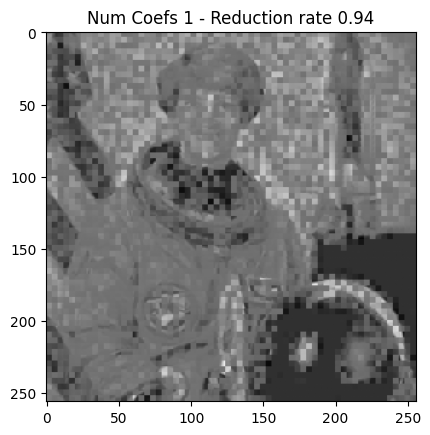

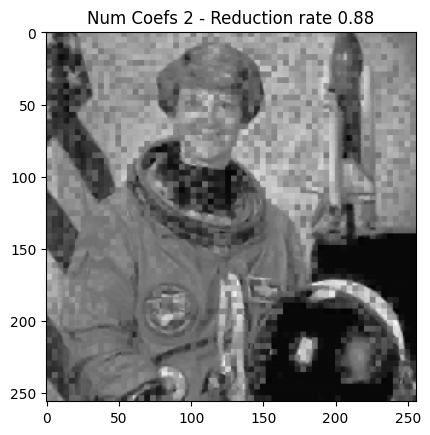

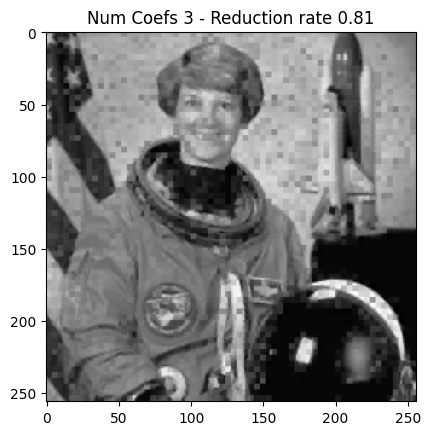

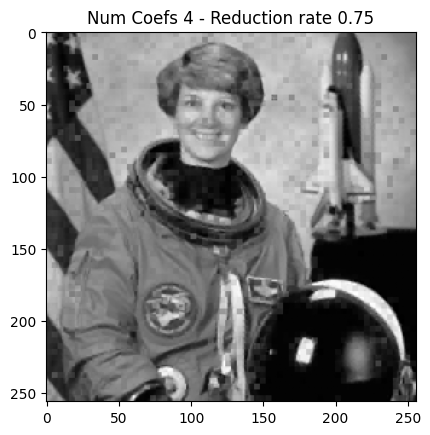

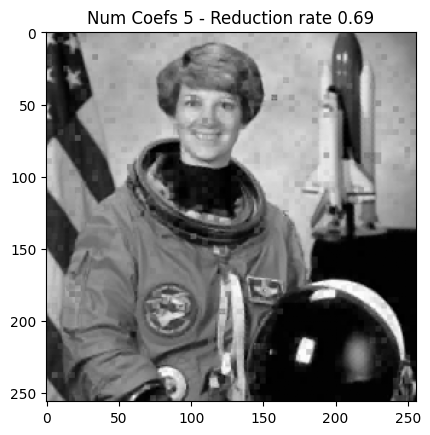

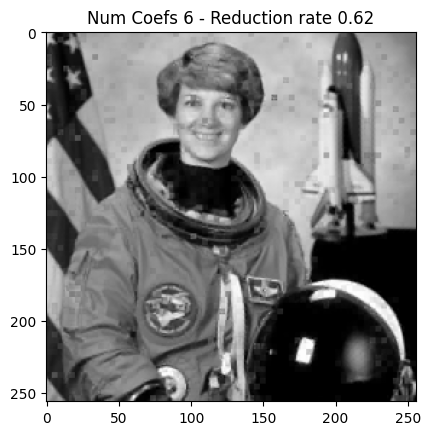

In [156]:
# Step 6: Reconstruct the image with different number of non-zero coefficients
transform_algorithms = [
     {'transform_n_nonzero_coefs': 1},
     {'transform_n_nonzero_coefs': 2},
     {'transform_n_nonzero_coefs': 3},
     {'transform_n_nonzero_coefs': 4},
     {'transform_n_nonzero_coefs': 5},
     {'transform_n_nonzero_coefs': 6},
]
for kwargs in transform_algorithms:
    d_learner.set_params(transform_algorithm='lars', **kwargs)
    # find the sparse representaion fo the patches
    sparse_reps = d_learner.transform(patches)### YOUR CODE HERE ###

    # reconstruct the patches from their sparse representations and the learned dictionary
    recon_patches =sparse_reps@D### YOUR CODE HERE ###

    # add the mean to the reconstruction
    recon_patches += mean ### YOUR CODE HERE ###

    # reshape recon_patches to num_patches x pH x pW
    recon_patches = np.reshape(recon_patches, (recon_patches.shape[0], pH, pW))  ### YOUR CODE HERE ###

    # put all the patches back into the reconstructed image
    recon = patches_to_img(recon_patches, pH, pW, H//2, W//2)

    plt.imshow(recon, cmap='gray', vmin=0, vmax=1)
    plt.title('Num Coefs %d - Reduction rate %.02f' %(kwargs['transform_n_nonzero_coefs'],
                                                   (1.0 - float(kwargs['transform_n_nonzero_coefs']) / (pH * pW)) ))
    plt.show()